# Import

In [1]:
import os
import sys
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim
from torchvision import transforms
from torchvision.utils import save_image
from collections import OrderedDict

import rff
from PIL import Image
from tqdm import tqdm
import imageio

from torchngp import functional
import util

# Parameters

In [2]:
# Parameters

logdir = "final/231210_gauss_enc_low"
lr = 1e-2
seed = 143
full_dataset = False
image_id = 15
hidden_dim = 24
num_layers = 2
num_epochs = 10000
batch_size = 2**17
input_dim = 2
encoding = 'gaussian'

# Helper Functions

In [3]:
@torch.no_grad()
def render_image(net, ncoords, image_shape, mean, std, batch_size, input_dim) -> torch.Tensor:
    C, H, W = image_shape
    parts = []
    for batch in ncoords.reshape(-1, input_dim).split(batch_size):
        parts.append(net(batch))
    img = torch.cat(parts, 0)
    img = img.view((H, W, C)).permute(2, 0, 1)
    img = torch.clip(img * std + mean, 0, 1)
    return img

class Trainer():
    def __init__(self, representation, batch_size, num_epochs, lr=1e-3, print_freq=1):
        """Model to learn a representation of a single datapoint.

        Args:
            representation (siren.Siren): Neural net representation of image to
                be trained.
            lr (float): Learning rate to be used in Adam optimizer.
            print_freq (int): Frequency with which to print losses.
        """
        self.representation = representation
        self.optimizer = torch.optim.Adam(self.representation.parameters(), lr=lr)
        self.print_freq = print_freq
        self.steps = 0  # Number of steps taken in training
        self.loss_func = torch.nn.MSELoss()
        self.best_vals = {'psnr': 0.0, 'loss': 1e8}
        self.logs = {'psnr': [], 'loss': []}
        # Store parameters of best model (in terms of highest PSNR achieved)
        self.best_model = OrderedDict((k, v.detach().clone()) for k, v in self.representation.state_dict().items())

    def train(self, encoords, nimg, num_steps):
        """Fit neural net to image.

        Args:
            coordinates (torch.Tensor): Tensor of coordinates.
                Shape (num_points, coordinate_dim).
            features (torch.Tensor): Tensor of features. Shape (num_points, feature_dim).
            num_iters (int): Number of iterations to train for.
        """                           
        # Train
        pbar = tqdm(range(n_steps), mininterval=0.1)
        pbar_postfix = {"loss": 0.0}
        encoords_flat = encoords.reshape(-1, encoords.shape[2])
        nimg_flat = nimg.view(nimg.shape[0], -1)
        for epoch in range(num_epochs):
            ids = torch.randperm(encoords_flat.shape[0])
            for batch in ids.split(batch_size):
                batch_coordinates = encoords_flat[batch]
                batch_features = nimg_flat[:, batch]

                batch_predicted = self.representation(batch_coordinates)
                optimizer.zero_grad()
                loss = self.loss_func(batch_predicted, batch_features.permute(1, 0))
                loss.backward()
                optimizer.step()

                # Calculate psnr
                pbar_postfix["loss"] = loss.item()
                pbar.set_postfix(**pbar_postfix, refresh=False)
                pbar.update()

            recimg = render_image(model, encoords, nimg.shape, mean, std, batch_size, encoords.shape[2])
            psnr, _ = functional.peak_signal_noise_ratio(
                img.unsqueeze(0), recimg.unsqueeze(0), 1.0
            )
            psnr = psnr.mean().item()
            pbar_postfix["psnr[dB]"] = psnr
            pbar_postfix["best psnr[dB]"] = self.best_vals['psnr']
            
            if psnr > self.best_vals['psnr']:
                self.best_vals['psnr'] = psnr
                # If model achieves best PSNR seen during training, update
                # model
                if epoch > int(num_epochs / 2.):
                    for k, v in self.representation.state_dict().items():
                        self.best_model[k].copy_(v)

# Initialization

In [4]:
# Set up torch and cuda
dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')

# Set random seeds
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

if full_dataset:
    min_id, max_id = 1, 24  # Kodak dataset runs from kodim01.png to kodim24.png
else:
    min_id, max_id = image_id, image_id
    
# Dictionary to register mean values (both full precision and half precision)
results = {'fp_bpp': [], 'hp_bpp': [], 'fp_psnr': [], 'hp_psnr': []}

# Create directory to store experiments
if not os.path.exists(logdir):
    os.makedirs(logdir)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


# Load Image

In [5]:
# Fit images

print(f'Image {image_id}')

# Load image
img = imageio.imread(f"kodak-dataset/kodim{str(image_id).zfill(2)}.png")

# Read image
img = torch.tensor(img).permute(2, 0, 1).float() / 255.0
img = img.to(device)
coords = functional.make_grid(img.shape[1:], indexing="xy", device=device)
ncoords = functional.normalize_uv(coords, coords.shape[:-1], indexing="xy")

# Compute image stats
mean, std = img.mean((1, 2), keepdim=True), img.std((1, 2), keepdim=True)
n_pixels = np.prod(img.shape[1:])

# Normalize image
nimg = (img - mean) / std

print(ncoords.shape)
print(nimg.shape)

/tmp/ipykernel_1283887/2612148782.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(f"kodak-dataset/kodim{str(image_id).zfill(2)}.png")


Image 15
torch.Size([512, 768, 2])
torch.Size([3, 512, 768])


# Encoding

In [6]:
# Encoding

if encoding == 'positional':
    encoder = rff.layers.PositionalEncoding(sigma=0.5, m=10)
elif encoding == 'gaussian':
    encoder = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=256)
else:
    encoder = lambda x: x

encoords = encoder(ncoords)
encoords = encoords.to(device, dtype)

print(encoords.shape)

torch.Size([512, 768, 512])


In [7]:
encoords

tensor([[[-0.7550, -0.9999, -0.9911,  ..., -0.5291,  0.5300, -0.8535],
         [-0.7368, -0.9960, -0.9511,  ..., -0.6909,  0.4542, -0.9314],
         [-0.7181, -0.9861, -0.7241,  ..., -0.8237,  0.3750, -0.9807],
         ...,
         [ 0.9158,  0.7288,  0.8899,  ..., -0.4381,  0.0958,  0.2898],
         [ 0.9264,  0.7793,  0.9996,  ..., -0.6120,  0.1820,  0.4526],
         [ 0.9363,  0.8252,  0.9129,  ..., -0.7603,  0.2669,  0.6014]],

        [[-0.7433, -0.9959, -1.0000,  ..., -0.1969,  0.5450, -0.7615],
         [-0.7247, -0.9999, -0.9037,  ..., -0.3925,  0.4700, -0.8630],
         [-0.7057, -0.9980, -0.6297,  ..., -0.5717,  0.3915, -0.9380],
         ...,
         [ 0.9227,  0.6543,  0.9410,  ..., -0.0939,  0.0780,  0.1366],
         [ 0.9329,  0.7105,  0.9948,  ..., -0.2948,  0.1644,  0.3076],
         [ 0.9424,  0.7625,  0.8530,  ..., -0.4833,  0.2496,  0.4692]],

        [[-0.7313, -0.9813, -0.9923,  ...,  0.1605,  0.5599, -0.6508],
         [-0.7124, -0.9932, -0.8414,  ..., -0

# Network

In [8]:
# Network

class CompressionModule(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, hidden_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.hidden_dim = hidden_dim
        
        # Input layer
        self.input_layer = torch.nn.Linear(input_dim, hidden_dim)
        
        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
        
        # Output layer
        self.output_layer = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
        
        x = self.output_layer(x)
        return x

In [9]:
model = CompressionModule(
    input_dim=encoords.shape[2],
    output_dim=3,
    num_hidden_layers=num_layers,
    hidden_dim=hidden_dim,
)
model.to(device)

CompressionModule(
  (input_layer): Linear(in_features=512, out_features=24, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=24, out_features=24, bias=True)
  )
  (output_layer): Linear(in_features=24, out_features=3, bias=True)
)

In [10]:
# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = torch.nn.MSELoss()

# Estimation of total steps such that each pixel is selected num_epochs times
n_pixels = np.prod(img.shape[1:])
n_steps_per_epoch = max(n_pixels // batch_size, 1)
n_steps = int(num_epochs * n_steps_per_epoch)

# Training

In [11]:
trainer = Trainer(model, batch_size, num_epochs, lr=lr)
trainer.train(encoords, nimg, n_steps)

100%|██████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:16<00:00, 392.20it/s, best psnr[dB]=27, loss=0.0211, psnr[dB]=26.9]


# Display

Model size: 54.3kB
Full precision bpp: 1.11
Best training psnr: 26.95


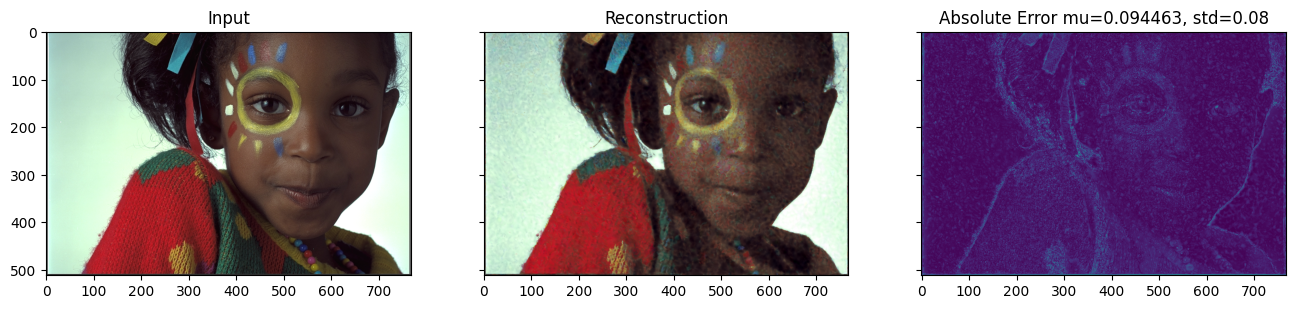

In [12]:
# Full Precision
model_size = util.model_size_in_bits(model) / 8000.
print(f'Model size: {model_size:.1f}kB')
fp_bpp = util.bpp(model=model, image=img)
print(f'Full precision bpp: {fp_bpp:.2f}')
print(f'Best training psnr: {trainer.best_vals["psnr"]:.2f}')

# Log full pre2ci2sion results
results['fp_bpp'].append(fp_bpp)
results['fp_psnr'].append(trainer.best_vals['psnr'])

# Display
imgrec = render_image(model, encoords, nimg.shape, mean, std, batch_size, encoords.shape[2])
err = (imgrec - img).abs().sum(0)
fig, axs = plt.subplots(1, 3, figsize=(16, 9), sharex=True, sharey=True)
axs[0].imshow(img.permute(1, 2, 0).cpu())
axs[0].set_title("Input")
axs[1].imshow(imgrec.permute(1, 2, 0).cpu())
axs[1].set_title("Reconstruction")
axs[2].imshow(err.cpu())
axs[2].set_title(f"Absolute Error mu={err.mean():2f}, std={err.std():.2f}")
plt.show()

# Saving image reconstruction
with torch.no_grad():
    save_image(imgrec.to('cpu'), logdir + f'/fp_reconstruction_{image_id}.png')

# Save best model
torch.save(trainer.best_model, logdir + f'/best_model_{image_id}.pt')

Model size: 27.2kB
Half precision bpp: 0.55
PSNR: 26.95


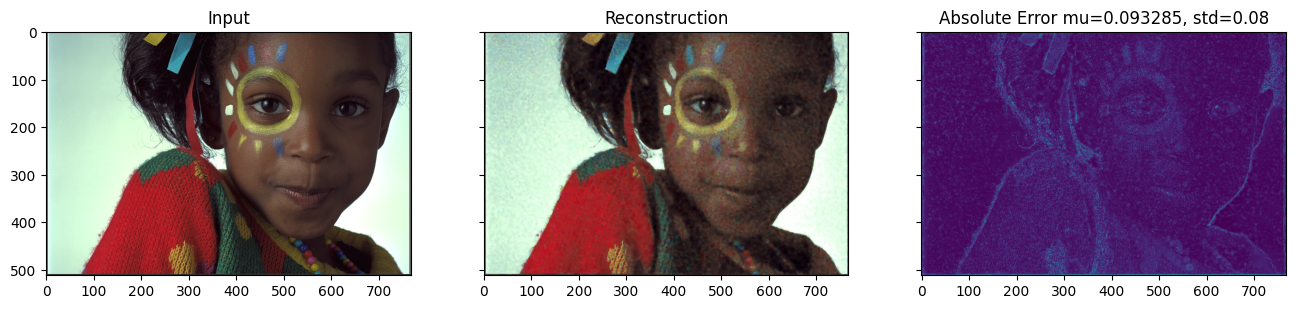

In [13]:
# Half Precision

model.load_state_dict(trainer.best_model)

half_model = model.half().to('cuda')
half_encoords = encoords.half().to('cuda')

model_size = util.model_size_in_bits(half_model) / 8000.
hp_bpp = util.bpp(model=half_model, image=img)
half_imgrec = render_image(half_model, half_encoords, nimg.shape, mean, std, batch_size, encoords.shape[2])
half_err = (half_imgrec - img).abs().sum(0)
half_psnr, _ = functional.peak_signal_noise_ratio(
    img.unsqueeze(0), half_imgrec.unsqueeze(0), 1.0
)

# Log full precision results
print(f'Model size: {model_size:.1f}kB')
print(f'Half precision bpp: {hp_bpp:.2f}')
print(f'PSNR: {half_psnr.mean().item():.2f}')
results['hp_bpp'].append(hp_bpp)
results['hp_psnr'].append(half_psnr.mean().item())

# Display
fig, axs = plt.subplots(1, 3, figsize=(16, 9), sharex=True, sharey=True)
axs[0].imshow(img.permute(1, 2, 0).cpu())
axs[0].set_title("Input")
axs[1].imshow(half_imgrec.permute(1, 2, 0).cpu())
axs[1].set_title("Reconstruction")
axs[2].imshow(half_err.cpu())
axs[2].set_title(f"Absolute Error mu={half_err.mean():2f}, std={half_err.std():.2f}")
plt.show()

# Saving image reconstruction
with torch.no_grad():
    save_image(half_imgrec.to('cpu'), logdir + f'/hp_reconstruction_{image_id}.png')

# Saving

In [14]:
print('Full results:')
print(results)
with open(logdir + f'/results.json', 'w') as f:
    json.dump(results, f)
    
# Compute and save aggregated results
results_mean = {key: util.mean(results[key]) for key in results}
with open(logdir + f'/results_mean.json', 'w') as f:
    json.dump(results_mean, f)

print('Aggregate results:')
print(f'Full precision, bpp: {results_mean["fp_bpp"]:.2f}, psnr: {results_mean["fp_psnr"]:.2f}')
print(f'Half precision, bpp: {results_mean["hp_bpp"]:.2f}, psnr: {results_mean["hp_psnr"]:.2f}')

Full results:
{'fp_bpp': [1.105712890625], 'hp_bpp': [0.5528564453125], 'fp_psnr': [26.95476531982422], 'hp_psnr': [26.954517364501953]}
Aggregate results:
Full precision, bpp: 1.11, psnr: 26.95
Half precision, bpp: 0.55, psnr: 26.95
